In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
import seaborn as sn
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold

In [3]:
dataset = pd.read_csv('data/dataset.csv', index_col=0)
# dataset = dataset.drop(columns=["index_x", "index_y", "index_x.1", "index_y.1", 'index'])

dataset.head()

,date,symbol,econ_branch,score,year,month,day,close,roi_month,roi_quarter,roi_halfyear,roi_year
0,2004-02-11,SU,Energy Minerals,0.953727,2004,2,11,13.285000,0.015807,-0.085058,0.048927,0.406473
1,2004-02-11,GGG,Producer Manufacturing,0.952753,2004,2,11,9.388889,-0.048047,-0.010888,0.087811,0.348402
2,2004-02-11,CWT,Utilities,0.934181,2004,2,11,14.720000,-0.002717,-0.068954,-0.070992,0.178668
3,2004-02-11,BLL,Process Industries,0.922862,2004,2,11,8.095000,0.006640,-0.023935,0.124923,0.361334
4,2004-02-11,APA,Energy Minerals,0.912117,2004,2,11,39.830002,0.008034,0.025860,0.082350,0.442882


<AxesSubplot:>

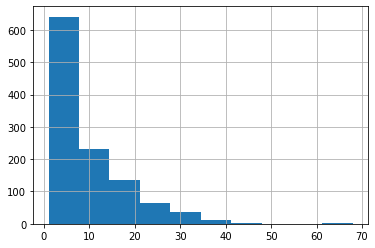

In [4]:
dataset.symbol.value_counts().hist()

Most of the symbols appear in the dataset only once.

<AxesSubplot:>

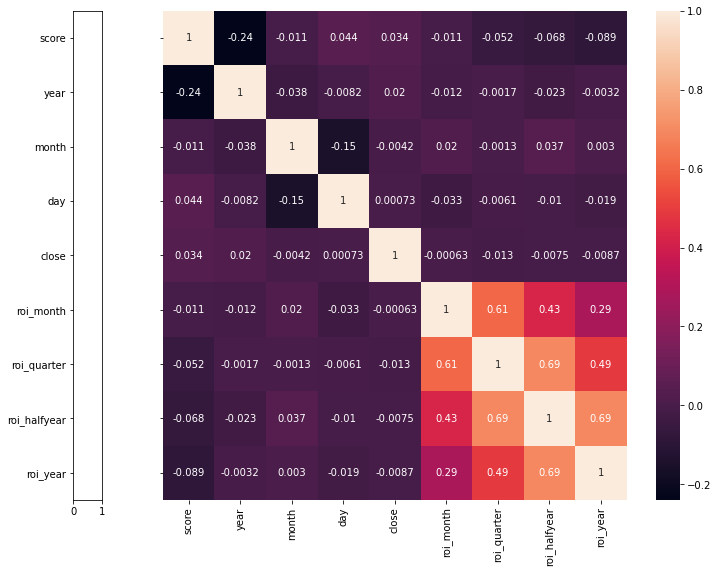

In [5]:

fig, ax = plt.subplots(1,2, figsize=(12, 9), sharey=True, gridspec_kw={'width_ratios': [1, 20]})
sn.heatmap(dataset.corr(), annot=True)

In [10]:
X = dataset[['score', 'close', 'year', 'econ_branch']]
y = dataset.iloc[:, -4:]

In [11]:
dummies = pd.get_dummies(X[['econ_branch']], drop_first=True)
X = pd.concat([X.drop(['econ_branch'],axis=1), dummies],axis=1)
X

,score,close,year,econ_branch_Communications,econ_branch_Consumer Durables,econ_branch_Consumer Non-Durables,econ_branch_Consumer Services,econ_branch_Distribution Services,econ_branch_Electronic Technology,econ_branch_Energy Minerals,...,econ_branch_Health Services,econ_branch_Health Technology,econ_branch_Industrial Services,econ_branch_Non-Energy Minerals,econ_branch_Process Industries,econ_branch_Producer Manufacturing,econ_branch_Retail Trade,econ_branch_Technology Services,econ_branch_Transportation,econ_branch_Utilities
0,0.953727,13.285000,2004,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.952753,9.388889,2004,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.934181,14.720000,2004,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.922862,8.095000,2004,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.912117,39.830002,2004,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10405,0.657795,90.209999,2021,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10406,0.651998,1423.270020,2021,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10407,0.650983,193.690002,2021,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10408,0.646593,53.529999,2021,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [13]:
# Let's make predictions for monthly returns

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train.roi_month)
DummyRegressor()
dummy_regr.score(X_test, y_test.roi_month) # R^2 for dummy regressor always inserting mean


-0.0009091658115434331

In [14]:
regr = LinearRegression()
regr.fit(X_train, y_train.roi_month)

y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test.roi_month, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test.roi_month, y_pred))

Coefficients: 
 [-2.58754006e-02 -1.47941560e-08 -3.33509934e-04 -3.60498957e-02
  3.68722367e-03 -3.65763807e-03 -3.62283216e-03 -1.02539159e-02
 -2.11653260e-02 -5.35156484e-03 -1.03534138e-02 -2.59743493e-02
 -1.98962365e-02 -7.56134063e-03 -2.90938301e-02 -9.74432557e-03
 -7.97106749e-03 -2.01072250e-03 -6.66985721e-03 -1.00750579e-02
 -1.27651544e-02]
Mean squared error: 0.01
Coefficient of determination: 0.00


In [15]:
regr = LinearRegression()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(regr, X, y.roi_month.to_frame(), scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.062 (0.002)


In [16]:
1 - ((y_test.roi_month - y_pred)**2).sum() / ((y_test.roi_month - y_test.roi_month.mean())**2).sum() # R^2 for linear regressor

0.0010593662595722586

In [17]:
xgb_regr = XGBRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(xgb_regr, X, y.roi_month.to_frame(), scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.062 (0.002)


In [18]:
model = XGBRegressor()
# fit model
model.fit(X_train, y_train.roi_month.to_frame())
# define new data
y_pred = model.predict(X_test)
1 - ((y_test.roi_month - y_pred)**2).sum() / ((y_test.roi_month - y_test.roi_month.mean())**2).sum()  # R^2 for XGB

0.02802893840303089

<AxesSubplot:xlabel='score', ylabel='roi_month'>

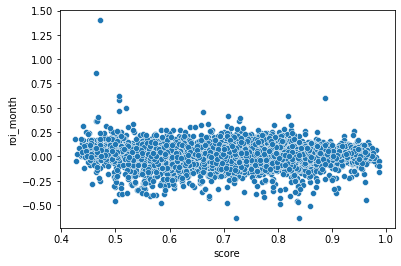

In [20]:
sn.scatterplot(x=X_train.score, y=y_train.roi_month)